# Workbook 03c1 - Edge Feature Preprocessing

**Objective:** Extract and align the 95 edge features from `background_edges.csv`
to the existing PyG edge index, producing `edge_features.npy` for use in Wb03c2.

**Pipeline:**
1. Load `background_edges.csv` (clId1, clId2, txId, feat#1 … feat#95)
2. Filter to labelled-universe edges (inner join with packed edge arrays)
3. Handle edge multiplicity (multiple txId per edge pair → aggregate)
4. Align to `edge_index.npy` row order
5. Save `edge_features.npy` + diagnostics

**No Optuna, no W&B - pure preprocessing.**


## 0. Configuration

In [7]:
import json, time, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

PROJECT_ROOT  = Path.cwd()
DATA_DIR      = PROJECT_ROOT / "DATA"
RAW_DIR       = DATA_DIR / "raw"
PROCESSED     = DATA_DIR / "processed"
ARRAYS_DIR    = PROCESSED / "arrays"
ARTIFACTS_DIR = PROCESSED / "artifacts"
PACK_DIR      = ARTIFACTS_DIR / "packed"
RESULTS_DIR   = PROJECT_ROOT / "results"
WB03C1_DIR    = RESULTS_DIR / "wb03c1"
WB03C1_DIR.mkdir(parents=True, exist_ok=True)

# background_edges file
BG_EDGES_PATH = RAW_DIR / "background_edges.csv"

# Fallback: check common locations
if not BG_EDGES_PATH.exists():
    for candidate in [
        DATA_DIR / "background_edges.csv",
        PROJECT_ROOT / "background_edges.csv",
        DATA_DIR / "raw" / "background_edges.csv",
    ]:
        if candidate.exists():
            BG_EDGES_PATH = candidate
            break

print(f"background_edges.csv: {BG_EDGES_PATH}")
print(f"  exists: {BG_EDGES_PATH.exists()}")
if BG_EDGES_PATH.exists():
    # Quick size check
    import os
    size_mb = os.path.getsize(BG_EDGES_PATH) / 1e6
    print(f"  size: {size_mb:.1f} MB")


background_edges.csv: /run/media/ncarcasci/Volume/THESIS/DATA/background_edges.csv
  exists: True
  size: 82877.4 MB


## 1. Load Packed Edge Arrays

In [8]:
# From Wb02: packed edge arrays for labelled subgraphs
edges_pack        = np.load(PACK_DIR / "edges_by_ccid.npz")
nodes_pack        = np.load(PACK_DIR / "nodes_by_ccid.npz")
unique_cc_edges   = edges_pack["unique_cc_edges"].astype(np.int64)
edge_ptr          = edges_pack["edge_ptr"].astype(np.int64)
edge_src_row_perm = edges_pack["edge_src_row_perm"].astype(np.int64)
edge_dst_row_perm = edges_pack["edge_dst_row_perm"].astype(np.int64)

# Reconstruct the full edge list (global node row indices)
# These are the edges our models already use, in exact order.
n_edges = len(edge_src_row_perm)
print(f"Labelled-universe edges: {n_edges:,}")
print(f"Subgraphs with edges: {len(unique_cc_edges):,}")

# Load node info to get clId mapping
nodes = pd.read_parquet(PROCESSED / "parquet" / "nodes.parquet")
# row_idx to clId mapping
row_to_clid = nodes["clId"].values  # row i → clId
print(f"Node rows: {len(row_to_clid):,}")


Labelled-universe edges: 367,137
Subgraphs with edges: 121,810
Node rows: 444,521


## 2. Load background_edges.csv

In [9]:
# Our labelled edges are defined by (global_row_src, global_row_dst)
# which map to (clId_src, clId_dst) via row_to_clid.
#
# Strategy:
# 1. Convert our packed edge arrays to (clId1, clId2) pairs
# 2. Join with background_edges on (clId1, clId2)
# 3. Handle multiplicity: multiple txId per (clId1, clId2) to mean features

# Step 1: Build lookup of our edge pairs
our_clid1 = row_to_clid[edge_src_row_perm]  # shape (n_edges,)
our_clid2 = row_to_clid[edge_dst_row_perm]  # shape (n_edges,)

our_edges_df = pd.DataFrame({
    "clId1": our_clid1,
    "clId2": our_clid2,
    "edge_idx": np.arange(n_edges),  # preserve original order
})
print(f"Our edges: {len(our_edges_df):,}")

# Check for duplicate (clId1, clId2) pairs in our edges
n_unique_pairs = our_edges_df.groupby(["clId1", "clId2"]).ngroups
n_multi = n_edges - n_unique_pairs
print(f"Unique (clId1, clId2) pairs: {n_unique_pairs:,}")
print(f"Duplicate edges (multigraph): {n_multi:,} ({100*n_multi/n_edges:.1f}%)")


Our edges: 367,137
Unique (clId1, clId2) pairs: 343,192
Duplicate edges (multigraph): 23,945 (6.5%)


In [10]:
t0 = time.time()

# Read header first to confirm columns
with open(BG_EDGES_PATH, "r") as f:
    header = f.readline().strip().split(",")
print(f"Columns ({len(header)}): {header[:5]} ... {header[-3:]}")

feat_cols = [c for c in header if c.startswith("feat#")]
print(f"Feature columns: {len(feat_cols)}")
assert len(feat_cols) == 95, f"Expected 95 feature columns, got {len(feat_cols)}"

# Load with streaming aggregation to avoid OOM
import os
try:
    from tqdm import tqdm
except Exception:
    class tqdm:
        def __init__(self, *args, **kwargs): pass
        def update(self, *args, **kwargs): pass
        def close(self): pass

file_size_bytes = os.path.getsize(BG_EDGES_PATH)
file_size_gb = file_size_bytes / 1e9

# Build pair-key sets for fast membership checks
our_pair_keys = ((our_clid1.astype("uint64") << 32) | our_clid2.astype("uint64"))
our_keys = set(our_pair_keys.tolist())
our_keys_rev = set(((our_clid2.astype("uint64") << 32) | our_clid1.astype("uint64")).tolist())
our_keys_union = our_keys | our_keys_rev
our_keys_union_arr = np.fromiter(our_keys_union, dtype="uint64")
n_our_pairs = len(our_keys)

usecols = ["clId1", "clId2"] + feat_cols
dtype = {"clId1": "int64", "clId2": "int64", **{c: "float32" for c in feat_cols}}
chunksize = 250_000

agg_parts = []
matched_keys = set()
total_rows = 0
total_kept = 0

with open(BG_EDGES_PATH, "r") as f:
    pbar = tqdm(total=file_size_bytes, unit="B", unit_scale=True, desc="Reading background_edges")
    last_pos = f.tell()
    chunk_iter = pd.read_csv(
        f,
        chunksize=chunksize,
        usecols=usecols,
        dtype=dtype,
    )
    for chunk in chunk_iter:
        total_rows += len(chunk)
        keys = (chunk["clId1"].to_numpy(dtype="uint64") << 32) | chunk["clId2"].to_numpy(dtype="uint64")
        mask = np.isin(keys, our_keys_union_arr)
        if mask.any():
            filtered = chunk.loc[mask]
            total_kept += len(filtered)
            matched_keys.update(keys[mask].tolist())
            grp = filtered.groupby(["clId1", "clId2"], sort=False)[feat_cols].sum()
            grp["__count"] = filtered.groupby(["clId1", "clId2"], sort=False).size()
            agg_parts.append(grp.reset_index())
        pos = f.tell()
        if pos > last_pos:
            pbar.update(pos - last_pos)
            last_pos = pos
    pbar.close()

if not agg_parts:
    raise RuntimeError("No matching background edges found for our pairs")

bg_agg = pd.concat(agg_parts, ignore_index=True)
bg_agg = bg_agg.groupby(["clId1", "clId2"], sort=False)[feat_cols + ["__count"]].sum().reset_index()
bg_counts = bg_agg["__count"].copy()
bg_agg[feat_cols] = bg_agg[feat_cols].div(bg_agg["__count"], axis=0)

n_matched_fwd = len(matched_keys & our_keys)
n_matched_rev = len(matched_keys & our_keys_rev)
n_unmatched = max(n_our_pairs - n_matched_fwd - n_matched_rev, 0)

elapsed = time.time() - t0
print(f"\nScanned: {total_rows:,} rows  kept: {total_kept:,} rows  ({elapsed:.1f}s)")
print(f"Our unique pairs: {n_our_pairs:,}")
print(f"Matched (forward): {n_matched_fwd:,} ({100*n_matched_fwd/max(n_our_pairs,1):.1f}%)")
print(f"Matched (reverse): {n_matched_rev:,}")
print(f"Unmatched: {n_unmatched:,}")
print(f"Aggregated background edges (matched pairs only): {len(bg_agg):,}")

# Memory usage for aggregated table only
print(f"bg_agg memory: {bg_agg.memory_usage(deep=True).sum() / 1e9:.2f} GB")


Columns (98): ['clId1', 'clId2', 'txId', 'feat#1', 'feat#2'] ... ['feat#93', 'feat#94', 'feat#95']
Feature columns: 95


Reading background_edges: 100%|██████████| 82.9G/82.9G [11:18<00:00, 122MB/s] 



Scanned: 196,215,606 rows  kept: 367,137 rows  (679.1s)
Our unique pairs: 343,192
Matched (forward): 343,192 (100.0%)
Matched (reverse): 14,672
Unmatched: 0
Aggregated background edges (matched pairs only): 343,192
bg_agg memory: 0.27 GB


## 3. Filter to Labelled-Universe Edges

In [11]:
# Step 2: Join with background_edges (stats from streaming scan)
print(f"Our edge pairs: {n_our_pairs:,}")
print(f"Matched (forward): {n_matched_fwd:,} ({100*n_matched_fwd/max(n_our_pairs,1):.1f}%)")
print(f"Matched (reverse): {n_matched_rev:,}")
print(f"Unmatched: {n_unmatched:,}")


Our edge pairs: 343,192
Matched (forward): 343,192 (100.0%)
Matched (reverse): 14,672
Unmatched: 0


In [13]:
# Step 3: Multiplicity stats for matched pairs
mult = bg_counts
print("Multiplicity stats (matched pairs only):")
print(f"  Mean:   {mult.mean():.2f}")
print(f"  Median: {mult.median():.0f}")
print(f"  Max:    {mult.max()}")
print(f"  >1 txId: {(mult > 1).sum():,} pairs")


Multiplicity stats (matched pairs only):
  Mean:   1.07
  Median: 1
  Max:    125
  >1 txId: 11,480 pairs


## 4. Align Features to Edge Index

In [14]:
# Merge: our_edges ← bg_agg on (clId1, clId2)
# Left join to preserve our edge order; unmatched to NaN to fill 0

merged = our_edges_df.merge(
    bg_agg, on=["clId1", "clId2"], how="left"
)

# Also try reverse join for edges that match in opposite direction
unmatched_mask = merged[feat_cols[0]].isna()
n_unmatched_fwd = unmatched_mask.sum()
print(f"Forward match: {n_edges - n_unmatched_fwd:,} / {n_edges:,}")

if n_unmatched_fwd > 0:
    # Try reverse: swap clId1/clId2 in background for unmatched rows
    unmatched_idx = merged.loc[unmatched_mask, "edge_idx"].values
    unmatched_pairs = our_edges_df.loc[
        our_edges_df["edge_idx"].isin(unmatched_idx)
    ].copy()
    unmatched_pairs = unmatched_pairs.rename(
        columns={"clId1": "clId2", "clId2": "clId1"}
    )

    rev_merge = unmatched_pairs.merge(
        bg_agg, on=["clId1", "clId2"], how="left"
    )
    # Rename back
    rev_merge = rev_merge.rename(
        columns={"clId1": "clId2", "clId2": "clId1"}
    )

    n_rev_matched = rev_merge[feat_cols[0]].notna().sum()
    print(f"Reverse match: {n_rev_matched:,}")

    # Fill in the reverse matches
    if n_rev_matched > 0:
        for fidx in rev_merge.index:
            if rev_merge.loc[fidx, feat_cols[0]] is not np.nan:
                eidx = int(rev_merge.loc[fidx, "edge_idx"])
                merged_row = merged.loc[merged["edge_idx"] == eidx].index[0]
                merged.loc[merged_row, feat_cols] = rev_merge.loc[fidx, feat_cols].values

final_unmatched = merged[feat_cols[0]].isna().sum()
print(f"\nFinal unmatched: {final_unmatched:,} / {n_edges:,} "
      f"({100*final_unmatched/n_edges:.2f}%)")
print("Filling unmatched with 0 (sentinel for missing bin)")

# Sort by edge_idx to restore original order
merged = merged.sort_values("edge_idx").reset_index(drop=True)

# Extract feature matrix
edge_features = merged[feat_cols].fillna(0).values.astype(np.float32)
print(f"\nEdge feature matrix: {edge_features.shape}")
assert edge_features.shape[0] == n_edges, "Row count mismatch!"
assert edge_features.shape[1] == 95, "Feature count mismatch!"


Forward match: 367,137 / 367,137

Final unmatched: 0 / 367,137 (0.00%)
Filling unmatched with 0 (sentinel for missing bin)

Edge feature matrix: (367137, 95)


## 5. Diagnostics

In [15]:
# Feature statistics
print("="*60)
print("EDGE FEATURE DIAGNOSTICS")
print("="*60)

# Check if features are binned integers or continuous
sample = edge_features[:1000]
n_unique_per_feat = np.array([len(np.unique(edge_features[:, i]))
                               for i in range(95)])

print(f"\nUnique values per feature:")
print(f"  Min:    {n_unique_per_feat.min()}")
print(f"  Median: {np.median(n_unique_per_feat):.0f}")
print(f"  Max:    {n_unique_per_feat.max()}")
print(f"  Mean:   {n_unique_per_feat.mean():.1f}")

is_likely_binned = n_unique_per_feat.max() < 50
print(f"\nLikely binned integers: {is_likely_binned}")

# Missingness
zero_rate = (edge_features == 0).mean(axis=0)
print(f"\nZero rate per feature:")
print(f"  Min:  {zero_rate.min():.4f}")
print(f"  Mean: {zero_rate.mean():.4f}")
print(f"  Max:  {zero_rate.max():.4f}")

# Value range
print(f"\nValue range:")
print(f"  Global min: {edge_features.min():.4f}")
print(f"  Global max: {edge_features.max():.4f}")
print(f"  Global mean: {edge_features.mean():.4f}")
print(f"  Global std: {edge_features.std():.4f}")

# Feature correlation summary
if edge_features.shape[0] > 10000:
    corr_sample = edge_features[np.random.choice(
        edge_features.shape[0], 10000, replace=False)]
else:
    corr_sample = edge_features
corr = np.corrcoef(corr_sample.T)
upper = corr[np.triu_indices_from(corr, k=1)]
print(f"\nPairwise correlation (upper triangle):")
print(f"  Mean: {upper.mean():.4f}")
print(f"  Max:  {upper.max():.4f}")
print(f"  |r|>0.9: {(np.abs(upper) > 0.9).sum()} pairs")


EDGE FEATURE DIAGNOSTICS

Unique values per feature:
  Min:    3
  Median: 576
  Max:    36516
  Mean:   2283.7

Likely binned integers: False

Zero rate per feature:
  Min:  0.0000
  Mean: 0.4402
  Max:  0.9999

Value range:
  Global min: -1.0000
  Global max: 98.0000
  Global mean: 16.9402
  Global std: 23.3226

Pairwise correlation (upper triangle):
  Mean: nan
  Max:  nan
  |r|>0.9: 93 pairs


/home/ncarcasci/miniforge3/envs/thesis-env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ncarcasci/miniforge3/envs/thesis-env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


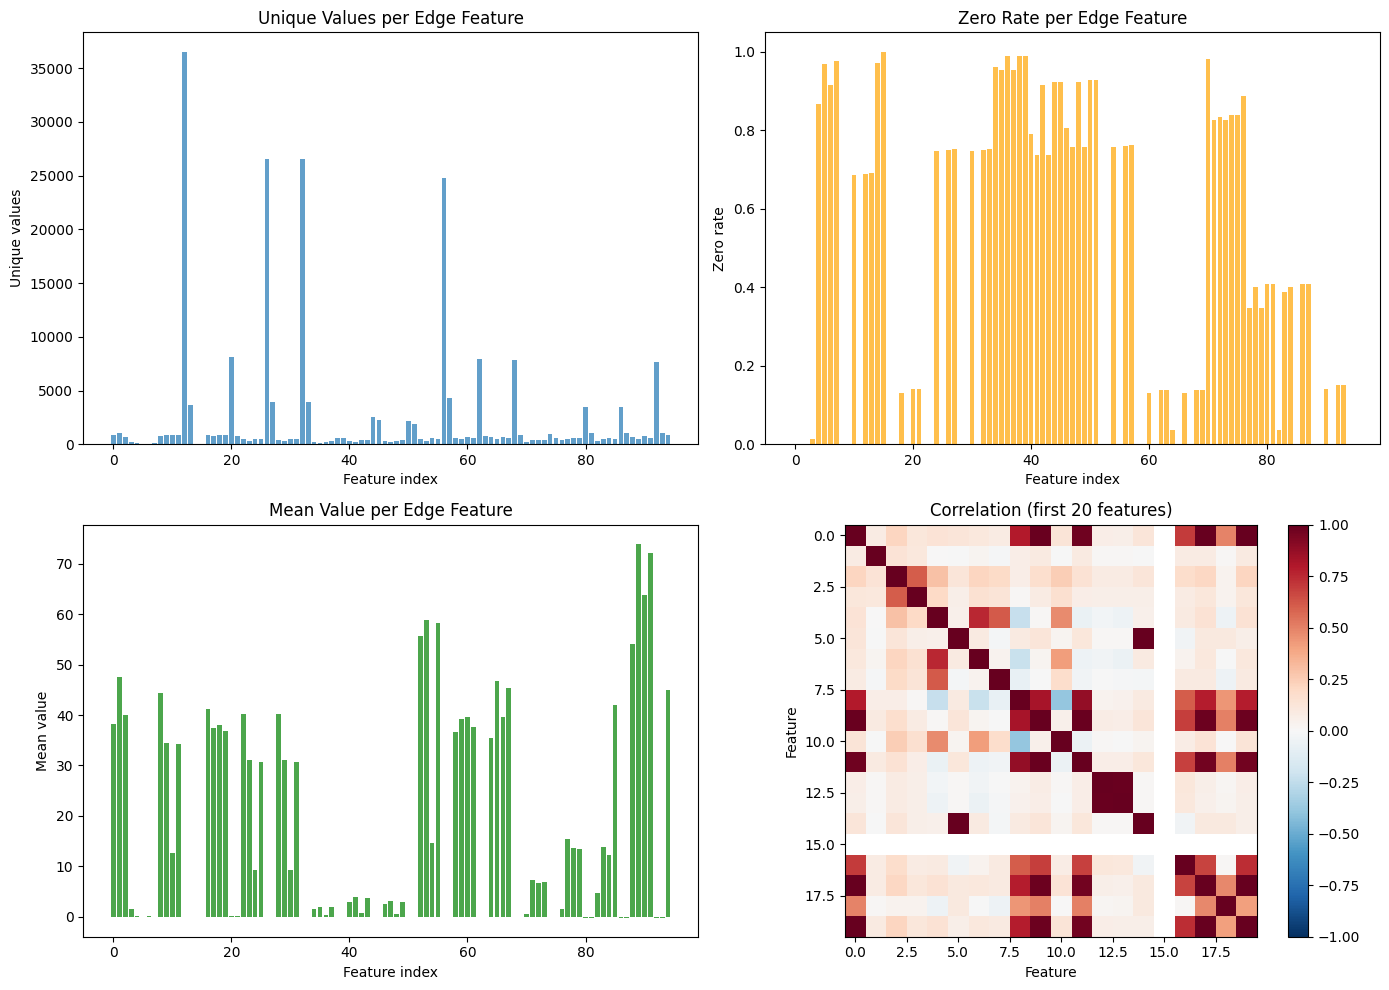

In [16]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution of unique values per feature
axes[0, 0].bar(range(95), n_unique_per_feat, alpha=0.7)
axes[0, 0].set(xlabel="Feature index", ylabel="Unique values",
               title="Unique Values per Edge Feature")

# 2. Zero rate per feature
axes[0, 1].bar(range(95), zero_rate, alpha=0.7, color="orange")
axes[0, 1].set(xlabel="Feature index", ylabel="Zero rate",
               title="Zero Rate per Edge Feature")

# 3. Feature means
feat_means = edge_features.mean(axis=0)
axes[1, 0].bar(range(95), feat_means, alpha=0.7, color="green")
axes[1, 0].set(xlabel="Feature index", ylabel="Mean value",
               title="Mean Value per Edge Feature")

# 4. Correlation heatmap (subset)
im = axes[1, 1].imshow(corr[:20, :20], cmap="RdBu_r", vmin=-1, vmax=1)
axes[1, 1].set(xlabel="Feature", ylabel="Feature",
               title="Correlation (first 20 features)")
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.savefig(WB03C1_DIR / "edge_feature_diagnostics.png", dpi=150,
            bbox_inches="tight")
plt.show()


## 5b. Dense Feature Subset

Many edge features are near-empty (zero rate > 80%). We create a reduced
subset keeping only features with zero rate < 0.5. This gives NNConv a
cleaner signal with a smaller edge MLP, which we test in Wb03c2.

In [19]:
# Select features with zero rate below threshold
ZERO_THRESHOLD = 0.5
dense_mask = zero_rate < ZERO_THRESHOLD
dense_indices = np.where(dense_mask)[0]
dense_cols = [feat_cols[i] for i in dense_indices]

edge_features_dense = edge_features[:, dense_mask].astype(np.float32)

print(f"Dense feature subset (zero rate < {ZERO_THRESHOLD}):")
print(f"  Features kept: {dense_mask.sum()} / 95")
print(f"  Features dropped: {(~dense_mask).sum()}")
print(f"  Shape: {edge_features_dense.shape}")

# Stats on what we kept vs dropped
kept_zr = zero_rate[dense_mask]
dropped_zr = zero_rate[~dense_mask]
print(f"\nKept features — zero rate: mean={kept_zr.mean():.3f}, max={kept_zr.max():.3f}")
print(f"Dropped features — zero rate: mean={dropped_zr.mean():.3f}, min={dropped_zr.min():.3f}")

# Quick look at the dense subset
print(f"\nDense subset value range: [{edge_features_dense.min():.1f}, {edge_features_dense.max():.1f}]")
print(f"Dense subset mean: {edge_features_dense.mean():.2f}")
print(f"Dense subset std: {edge_features_dense.std():.2f}")

# Show which features survived
print(f"\nKept feature indices: {dense_indices.tolist()}")

Dense feature subset (zero rate < 0.5):
  Features kept: 52 / 95
  Features dropped: 43
  Shape: (367137, 52)

Kept features — zero rate: mean=0.101, max=0.410
Dropped features — zero rate: mean=0.850, min=0.685

Dense subset value range: [-1.0, 98.0]
Dense subset mean: 29.11
Dense subset std: 24.40

Kept feature indices: [0, 1, 2, 3, 8, 9, 11, 16, 17, 18, 19, 20, 21, 22, 23, 25, 28, 29, 31, 52, 53, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]


## 6. Save Processed Data

In [20]:
# Save edge features
out_path = ARRAYS_DIR / "edge_features.npy"
np.save(out_path, edge_features)
print(f"Saved: {out_path}  shape={edge_features.shape}  "
      f"dtype={edge_features.dtype}")

# Save column names
cols_path = ARTIFACTS_DIR / "edge_feature_columns.json"
cols_path.write_text(json.dumps(feat_cols))
print(f"Saved: {cols_path}  ({len(feat_cols)} columns)")

# Save diagnostics JSON
diag = {
    "n_edges": int(n_edges),
    "n_features": 95,
    "n_matched_forward": int(n_edges - n_unmatched_fwd),
    "n_matched_reverse": int(n_rev_matched) if n_unmatched_fwd > 0 else 0,
    "n_unmatched_final": int(final_unmatched),
    "multigraph": {
        "n_directed_edges": int(n_edges),
        "n_unique_pairs": int(n_unique_pairs),
        "n_duplicate_edges": int(n_multi),
        "duplicate_pct": round(100 * n_multi / n_edges, 2),
        "note": "pair-level aggregation; duplicate edges share same feature vector",
    },
    "dense_subset": {
        "zero_threshold": ZERO_THRESHOLD,
        "n_features_dense": int(dense_mask.sum()),
        "n_features_dropped": int((~dense_mask).sum()),
    },
    "feature_stats": {
        "unique_values_per_feat": {
            "min": int(n_unique_per_feat.min()),
            "median": float(np.median(n_unique_per_feat)),
            "max": int(n_unique_per_feat.max()),
        },
        "zero_rate_mean": float(zero_rate.mean()),
        "value_range": [float(edge_features.min()), float(edge_features.max())],
        "likely_binned": bool(is_likely_binned),
    },
}
diag_path = WB03C1_DIR / "edge_feature_diagnostics.json"
diag_path.write_text(json.dumps(diag, indent=2))
print(f"Saved: {diag_path}")

# Save filtered background edges as parquet
parquet_path = PROCESSED / "parquet" / "background_edges_subset.parquet"
merged[["clId1", "clId2", "edge_idx"] + feat_cols].to_parquet(
    parquet_path, index=False
)
print(f"Saved: {parquet_path}  ({len(merged):,} rows)")

# Save dense feature subset
dense_path = ARRAYS_DIR / "edge_features_dense.npy"
np.save(dense_path, edge_features_dense)
print(f"Saved: {dense_path}  shape={edge_features_dense.shape}")

# Save dense column names and metadata
dense_meta = {
    "zero_threshold": ZERO_THRESHOLD,
    "n_features_total": 95,
    "n_features_dense": int(dense_mask.sum()),
    "dense_indices": dense_indices.tolist(),
    "dense_columns": dense_cols,
}
dense_meta_path = ARTIFACTS_DIR / "edge_feature_dense_meta.json"
dense_meta_path.write_text(json.dumps(dense_meta, indent=2))
print(f"Saved: {dense_meta_path}")

print(f"\n{'='*60}")
print("Edge feature preprocessing complete.")
print(f"  edge_features.npy:        {edge_features.shape} (all 95)")
print(f"  edge_features_dense.npy:  {edge_features_dense.shape} (zero rate < {ZERO_THRESHOLD})")
print(f"  Ready for Wb03c2 (NNConv)")
print(f"{'='*60}")


Saved: /run/media/ncarcasci/Volume/THESIS/DATA/processed/arrays/edge_features.npy  shape=(367137, 95)  dtype=float32
Saved: /run/media/ncarcasci/Volume/THESIS/DATA/processed/artifacts/edge_feature_columns.json  (95 columns)
Saved: /run/media/ncarcasci/Volume/THESIS/results/wb03c1/edge_feature_diagnostics.json
Saved: /run/media/ncarcasci/Volume/THESIS/DATA/processed/parquet/background_edges_subset.parquet  (367,137 rows)
Saved: /run/media/ncarcasci/Volume/THESIS/DATA/processed/arrays/edge_features_dense.npy  shape=(367137, 52)
Saved: /run/media/ncarcasci/Volume/THESIS/DATA/processed/artifacts/edge_feature_dense_meta.json

Edge feature preprocessing complete.
  edge_features.npy:        (367137, 95) (all 95)
  edge_features_dense.npy:  (367137, 52) (zero rate < 0.5)
  Ready for Wb03c2 (NNConv)


## 7. Verification

Quick sanity check: the i-th row of `edge_features.npy` must correspond
to the i-th edge in the packed edge arrays.


In [21]:
# Verify alignment
ef = np.load(ARRAYS_DIR / "edge_features.npy")
print(f"Loaded edge_features.npy: shape={ef.shape}")

# Check a few random edges
rng = np.random.RandomState(42)
for _ in range(5):
    i = rng.randint(0, n_edges)
    src_clid = row_to_clid[edge_src_row_perm[i]]
    dst_clid = row_to_clid[edge_dst_row_perm[i]]
    feats = ef[i]
    print(f"  Edge {i}: ({src_clid} → {dst_clid})  "
          f"feat[0]={feats[0]:.2f}  feat[-1]={feats[-1]:.2f}")

print(f"\nAll checks passed. edge_features.npy is aligned with edge arrays.")


Loaded edge_features.npy: shape=(367137, 95)
  Edge 121958: (868337502 → 906544522)  feat[0]=35.00  feat[-1]=46.00
  Edge 146867: (488312663 → 491590041)  feat[0]=48.00  feat[-1]=57.00
  Edge 131932: (912982415 → 912982413)  feat[0]=40.00  feat[-1]=50.00
  Edge 365838: (711851234 → 715900971)  feat[0]=43.00  feat[-1]=49.00
  Edge 259178: (700870378 → 739720136)  feat[0]=53.00  feat[-1]=62.00

All checks passed. edge_features.npy is aligned with edge arrays.
